# Boilerplate

In [1]:
import bayesian_multitarget_latent_factors as bmlf
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import xarray as xr

rng = np.random.default_rng(999)

In [2]:
def plot_all_B_dict(B_dict, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(13,8))
    else:
        fig = ax.get_figure()
    for i in range(B_dict['p']):
        bmlf.plot_col_basis_dict(B_dict, col_idx=i, ax=ax)
    ax.get_legend().set_visible(False)
    ax.set_title('')
    return fig, ax

## Fetch the Dataset

We use dataset from the R package `fds`
```
This data set consists of near-infrared reflectance spectra of 100 wheat samples, measured in 2 nm intervals from 1100 to 2500nm, and an associated response variables, the samples' moisture content.
```

In [3]:
from skfda.datasets import fetch_cran

x = fetch_cran('Moisturespectrum','fds')['Moisturespectrum']['x']
Y1 = fetch_cran('Moisturespectrum','fds')['Moisturespectrum']['y']
Y2 = fetch_cran('Moisturevalues','fds')['Moisturevalues']

/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/rdata/conversion/_conversion.py:294: UserWarning: Unknown encoding. Assumed ASCII.
  warnings.warn("Unknown encoding. Assumed ASCII.")  # noqa: B028
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/rdata/conversion/_conversion.py:294: UserWarning: Unknown encoding. Assumed ASCII.
  warnings.warn("Unknown encoding. Assumed ASCII.")  # noqa: B028
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/rdata/conversion/_conversion.py:856: UserWarning: Missing constructor for R class "fds". The underlying R object is returned instead.
  warnings.warn(
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/rdata/conversion/_conversion.py:294: UserWarning: Unknown encoding. Assumed ASCII.
  wa

## Center the Data

In [4]:
M1 = Y1.mean(axis=1)
M2 = Y2.mean()

Y1 = Y1 - M1
Y2 = Y2 - M2

### Subsample (otherwise the memory cost for some of the operation was too high, future steps are to improve on this)

In [5]:
x = x[::2]
Y1 = Y1[::2,:]

### A few exploratory analyses

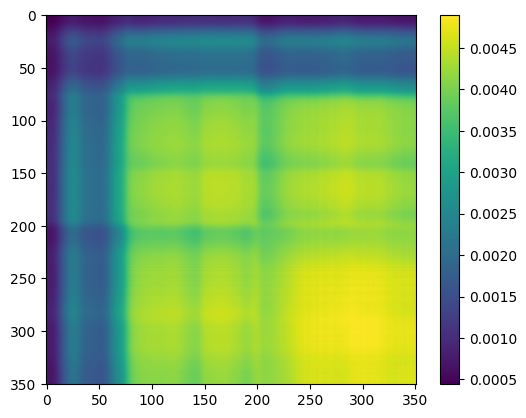

In [6]:
plt.imshow( np.cov(Y1) )
plt.colorbar()

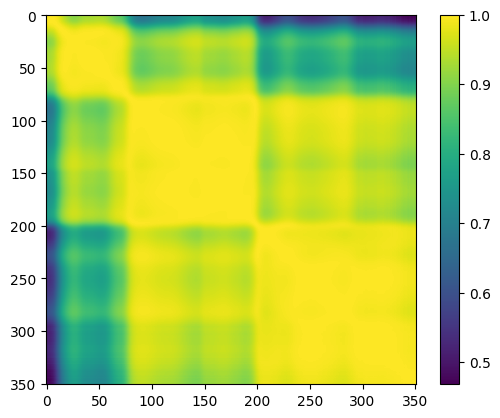

In [7]:
plt.imshow( np.corrcoef(Y1) )
plt.colorbar()

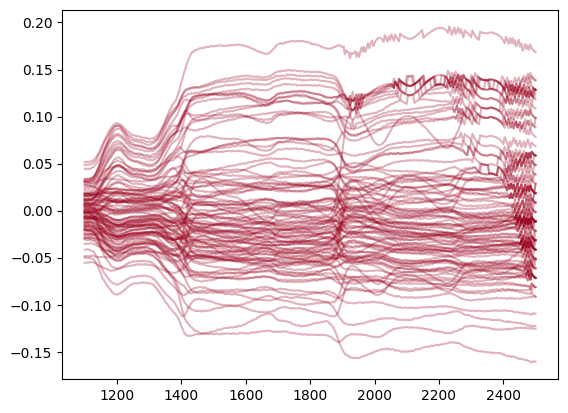

In [8]:
_ = plt.plot(x, Y1, c=bmlf.default_color_dict['Carmine'], alpha=0.3)

In [9]:
np.std(Y2)

1.3797401929348874

# Prior Selection

## Basis Function Selection

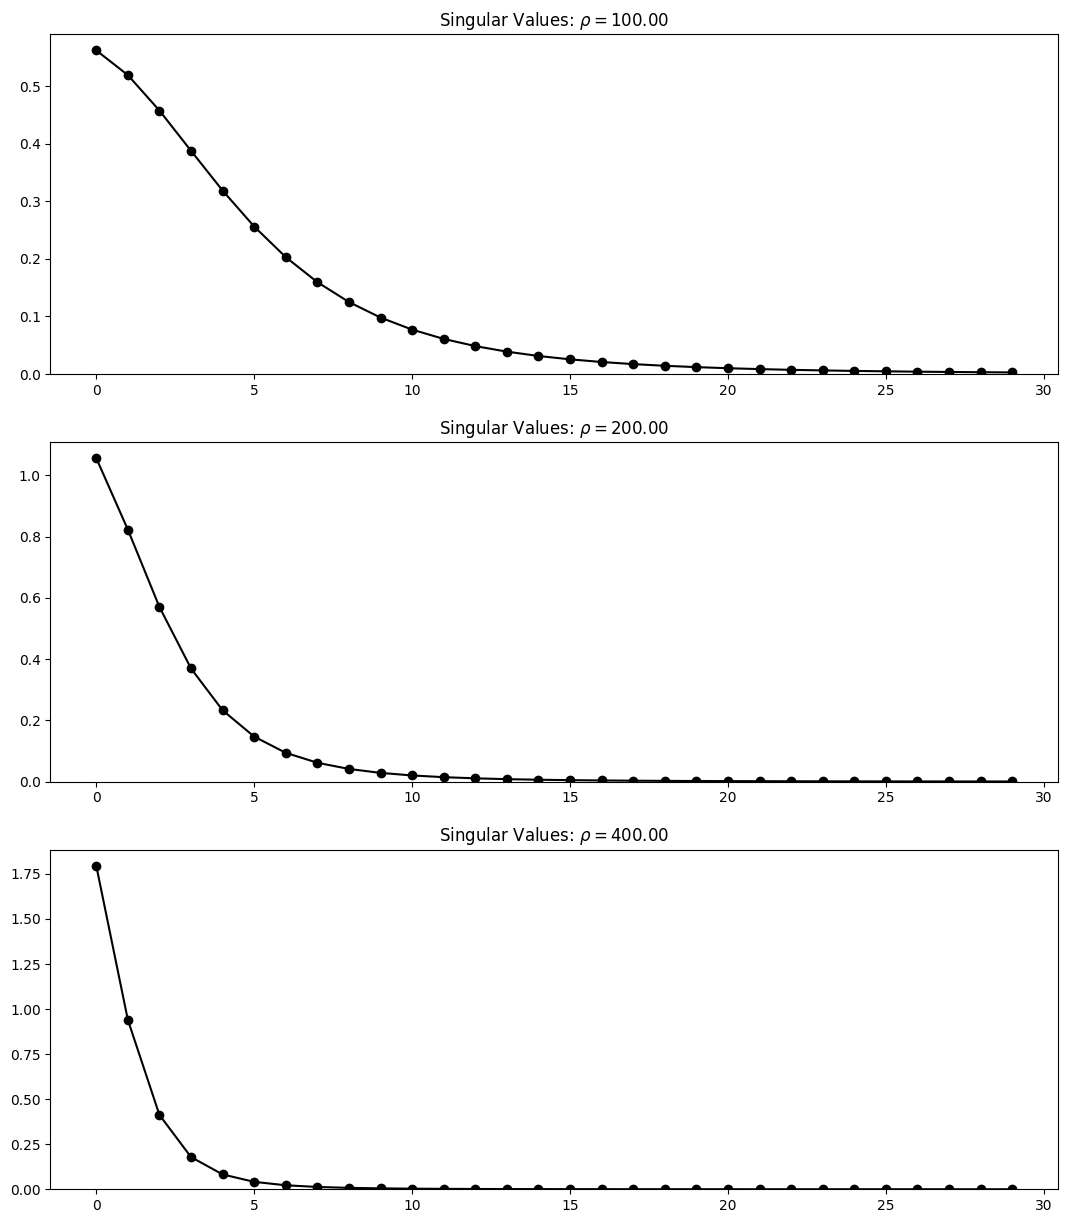

In [10]:
rho_list = [100,200,400]
sigma = 0.1
fig, axs = plt.subplots(3,1,figsize=(13,15))

for i in range(len(rho_list)):
    B = bmlf.build_matrix_B_from_gaussian_process_covariance(
        x,
        rho_list[i],
        num_singular_values=30,
        type_cov='matern_3_2',
        sigma=sigma,
    )
    U = bmlf.build_matrix_B_from_gaussian_process_covariance(
        x,
        rho_list[i],
        num_singular_values=30,
        type_cov='matern_3_2',
        use_S=False,
        sigma=sigma
    )
    S = np.square( np.diag(U['B'].T@B['B']) )
    axs[i].plot(S, 'ko-')
    axs[i].set_title('Singular Values: ' + r'$\rho = ' + f'{rho_list[i]:.2f}' + '$')
    axs[i].set_ylim(bottom=0.0)

(<Figure size 1300x800 with 1 Axes>, <Axes: xlabel='X Axis', ylabel='Value'>)

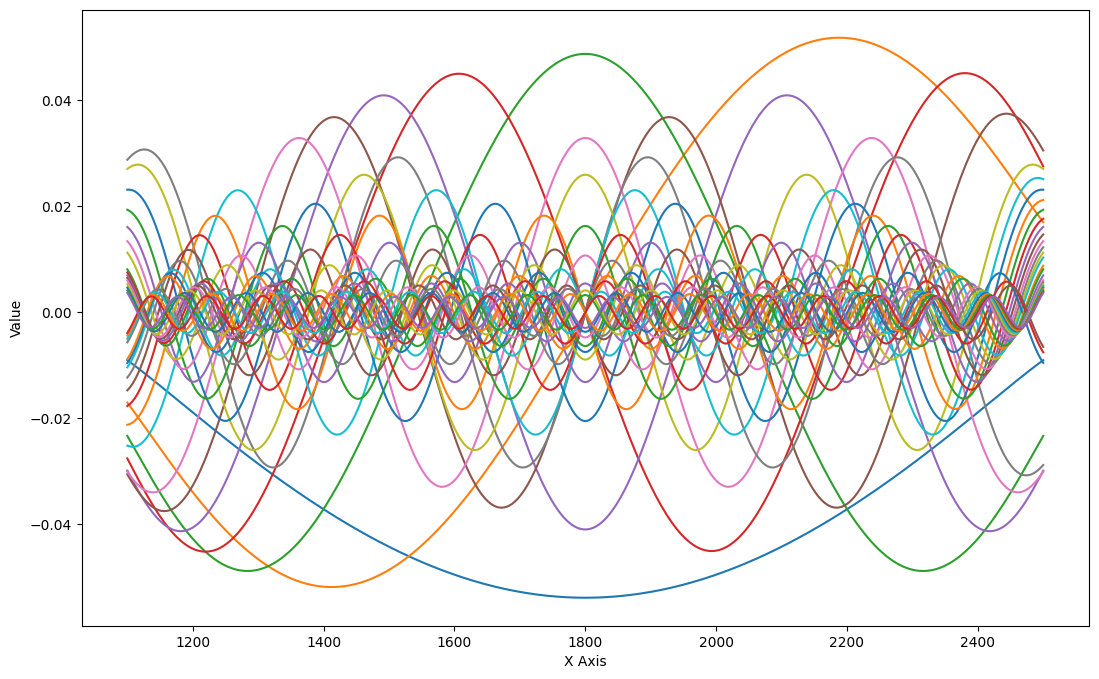

In [11]:
B1 = bmlf.build_matrix_B_from_gaussian_process_covariance(
    x,
    100,
    num_singular_values=35,
    sigma=0.1,
    nugget=0.0001,
    type_cov='matern_3_2',
    use_S=True,
)
plot_all_B_dict(B1)

## Trick the model by Choosing a "basis matrix" for the target (Moisture Value) 1x1 with value $1$

In [12]:
B2 = {
    'L': 1,
    'p': 1,
    't': np.array([0]),
    'B': np.array([[1]]),
}

## Select the Prior

The approach was based on the prior predictive properties, by choosing the values so that the model mathced the real observations at least in deviation from the mean.

To take into account the fact that $Y^{(2)}$ is not functional, we chose ψ_sigma_2 ~ 0, allowing θ2 to take care of the noise.

In [13]:
hyperparams_dict = \
bmlf.initialize_hyperparams_dict(
    k=3,
    v=8,
    nu=100,
    ψ_alpha=5,
    ψ_beta=4,
    ψ_sigma_1=0.04,
    ψ_sigma_2=1e-6,
    θ_alpha=5,
    θ_beta=4,
    θ_sigma_1=0.3,
    θ_sigma_2=1.0,
    alpha_1=2.1,
    alpha_2=2.78,
)

In [14]:
prior_dict = bmlf.make_prior_dict(
    hyperparams_dict,
    B1,
    B2,
    y1 = Y1.values,
    y2 = Y2[None,:],
    X = np.zeros((1, Y2.shape[0]))
)

Warning! This computation assumes same β parameter for θs... computing beta_sigma as the average of the two.


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

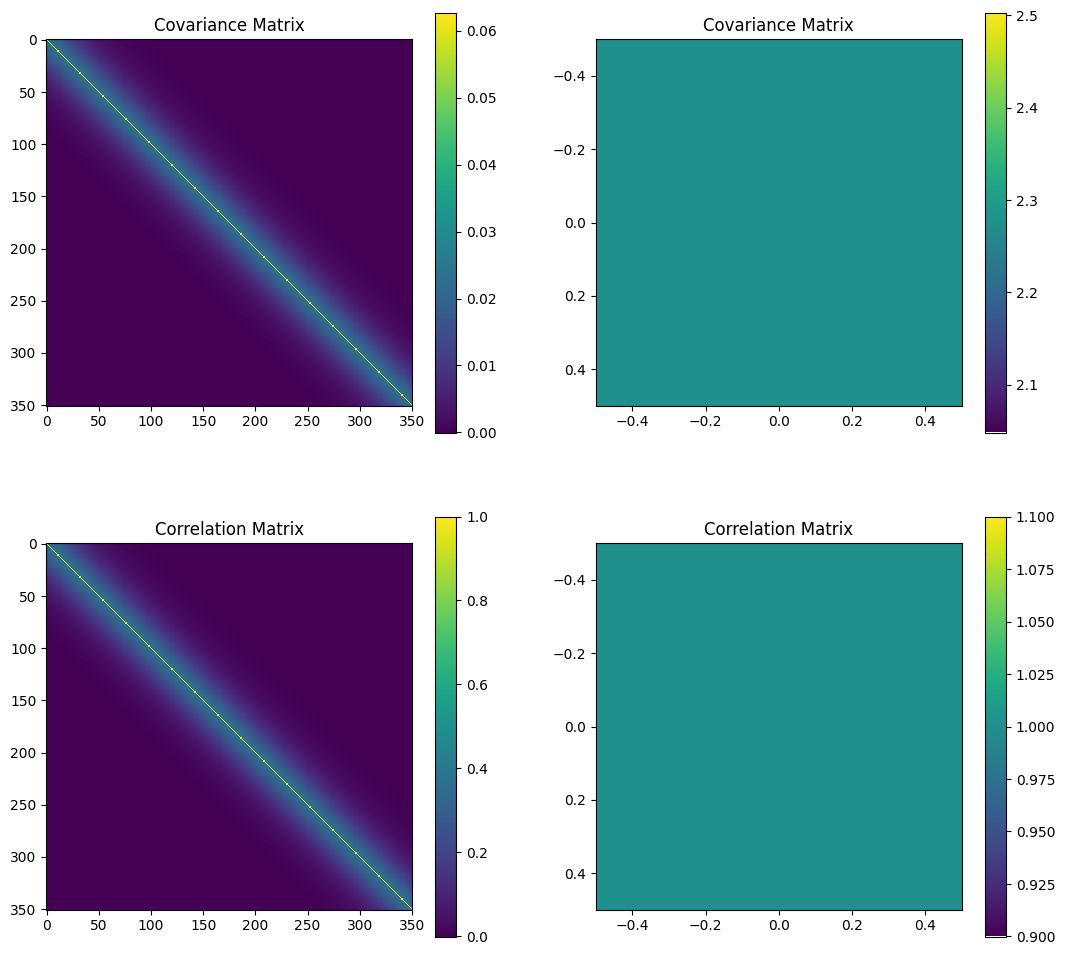

In [15]:
bmlf.prior_predictive_properties_from_prior_dict( prior_dict )

# Posterior Sampling

In [16]:
out_dir = './001_posterior'

In [17]:
from os.path import isfile

if not isfile(out_dir + '/idata.nc'):
    idata = \
    bmlf.sample_from_posterior_moore_penrose_trick(
        prior_dict,
        rng.integers(1000000),
        stan_file_path=None,
        output_dir=out_dir,
        laplace_draws=100,
        iter_warmup=500,
        iter_sampling=500,
        do_prior_sampling=False,
        max_treedepth=12,
        X_test=None,
    )
    idata.to_netcdf(out_dir + '/idata.nc')
else:
    idata = az.from_netcdf(out_dir + '/idata.nc')

# Exploration of Posterior Distribution

## Varimax

In [18]:
Varimax_res_xr = bmlf.Varimax_RSP(idata)

Rotated sample 0
Rotated sample 500
Rotated sample 1000
Rotated sample 1500
Starting iteration number 0
	 Previous objective fun =	inf
	 New objective fun =		5596.556
Starting iteration number 1
	 Previous objective fun =	5596.556
	 New objective fun =		321.756
Starting iteration number 2


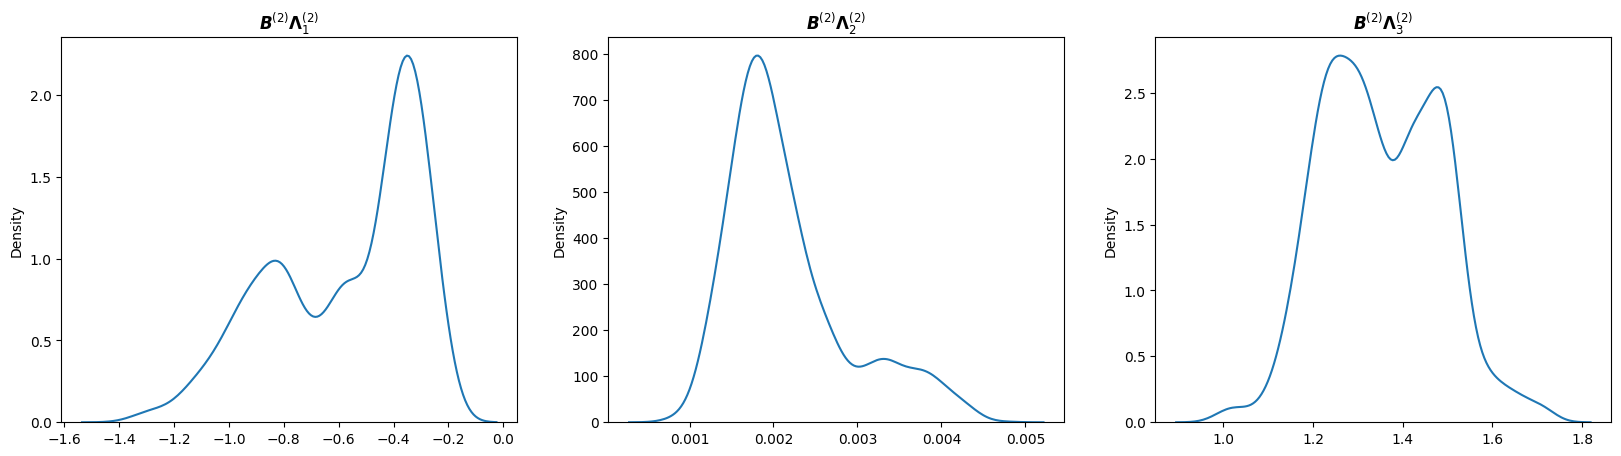

In [19]:
import seaborn as sns
fig, axs = plt.subplots(1,3,figsize=(20,5))
for i in range(3):
    ax = sns.kdeplot( bmlf.convert_chain_draw_to_sample( Varimax_res_xr['B2Λ2'].sel(target_2_dim_idx=0, latent_factor_idx=i) ).values , ax=axs[i])
    ax.set_title(r'$\boldsymbol{B}^{(2)}\boldsymbol{\Lambda}^{(2)}_{'+str(i+1)+'}$')

## Compute $\widehat{K}$ and show outliers

In [20]:
loo_res = az.loo(idata)
dict_loo_res = dict(loo_res)
def transform_array(arr, thresholds):
    """
    Transform a numpy array of floats to a numpy array of ints based on the given thresholds.

    Parameters:
    - arr: numpy array of floats.
    - thresholds: list of thresholds defining the ranges for transformation.

    Returns:
    - A numpy array of ints where each element is transformed based on the thresholds.
    """
    # Create an output array filled with zeros, initially assuming all values fall into the first category.
    out = np.zeros(arr.shape, dtype=int)
    
    # Iterate over the thresholds, assigning an increasing integer value
    # for each range defined by these thresholds.
    for i, threshold in enumerate(thresholds):
        out[arr > threshold] = i + 1

    return out
thresholds = [0.5, 0.7, 1.0]
class_pareto_k = transform_array( dict_loo_res['pareto_k'].values , thresholds )

/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Text(0, 0.5, '$\\eta_2$')

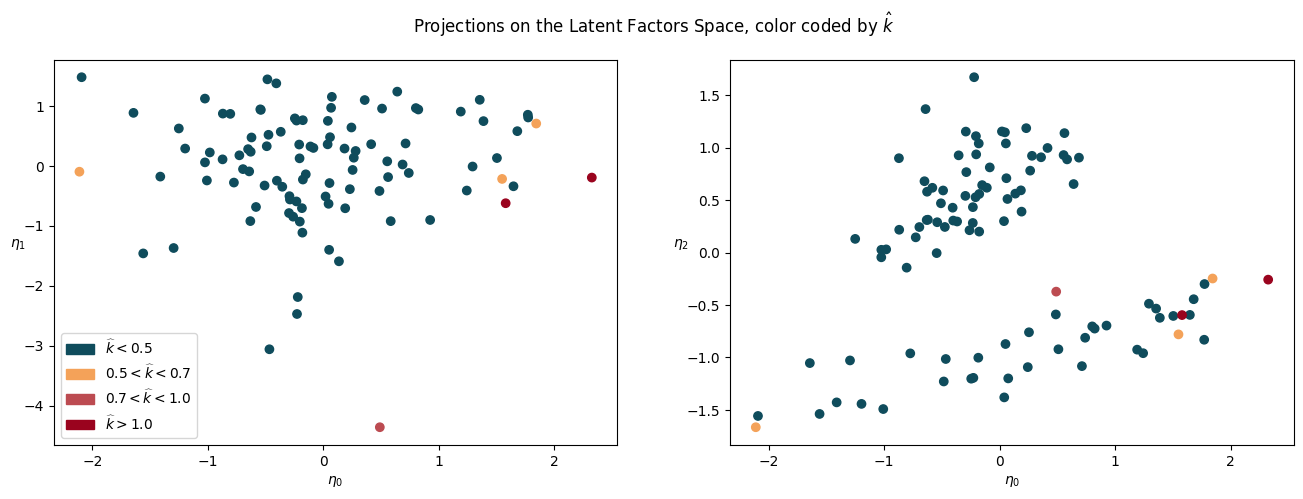

In [21]:
η_train_xr = \
bmlf.sample_projection_on_varimaxed_space(rng.integers(1000000), idata, Varimax_res_xr)
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1,2,figsize=(16,5))

col_seq = ['Midnight green', 'Sandy brown', 'Bittersweet shimmer', 'Carmine']
class_labels = ['Good', 'Ok', 'Bad', 'Very Bad']
class_labels = [r'$\widehat{k} < 0.5$', r'$0.5 < \widehat{k} < 0.7$', r'$0.7 < \widehat{k} < 1.0$', r'$\widehat{k} > 1.0$']

ax[0].scatter(η_train_xr.mean('chain').mean('draw').values.T[:,0],
              η_train_xr.mean('chain').mean('draw').values.T[:,1], c=[bmlf.default_color_dict[col_seq[i]] for i in class_pareto_k])
ax[1].scatter(η_train_xr.mean('chain').mean('draw').values.T[:,0],
              η_train_xr.mean('chain').mean('draw').values.T[:,2], c=[bmlf.default_color_dict[col_seq[i]] for i in class_pareto_k])

legend_patches = [mpatches.Patch(color=bmlf.default_color_dict[col_seq[i]], label=class_labels[i]) for i in range(len(col_seq))]
ax[0].legend(handles=legend_patches, loc='lower left')

fig.suptitle(r'Projections on the Latent Factors Space, color coded by $\hat{k}$')
ax[0].set_xlabel(r'$\eta_0$')
ax[0].set_ylabel(r'$\eta_1$', rotation=0)
ax[1].set_xlabel(r'$\eta_0$')
ax[1].set_ylabel(r'$\eta_2$', rotation=0)

## Show the Latent Factors

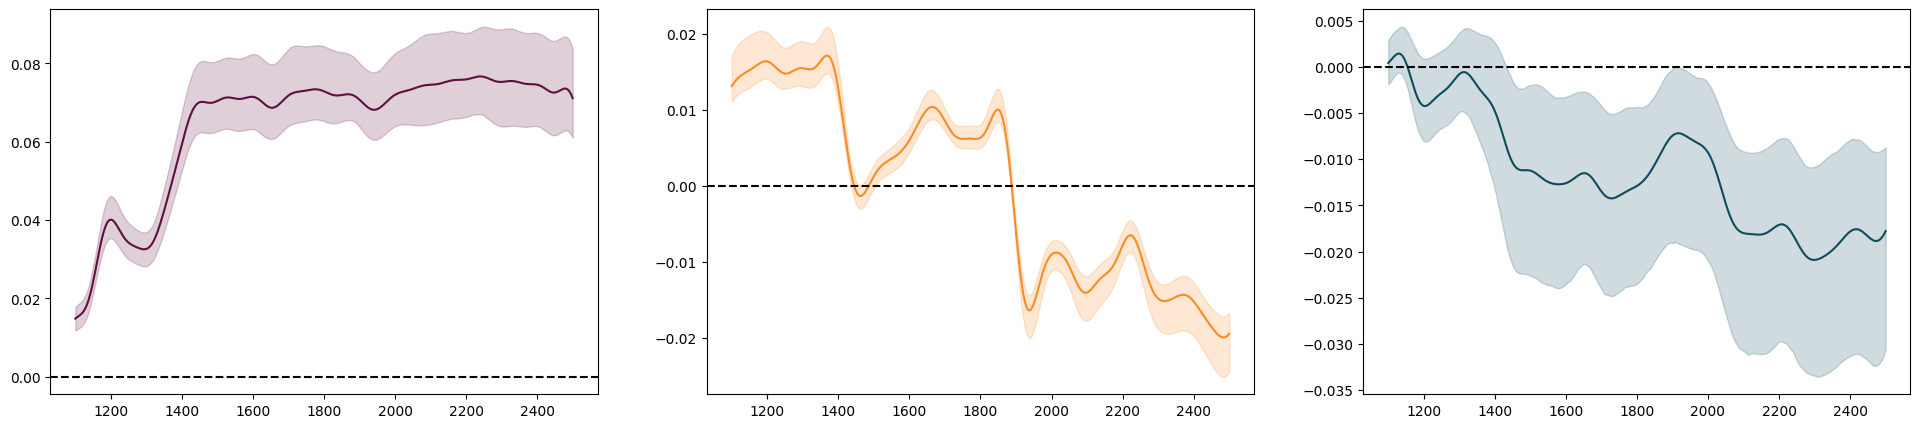

In [22]:
fig, axs = plt.subplots(1,3, figsize=(24,5), sharey=False)
for i in range(3):
    color = bmlf.default_color_dict[list(bmlf.default_color_dict)[(2*i)%9]]
    if i == 3:
        color = bmlf.default_color_dict[list(bmlf.default_color_dict)[2*i+1]]
    bmlf.uncertain_lineplot(idata.constant_data['t1'].values,
                            bmlf.convert_chain_draw_to_sample(
                                Varimax_res_xr['B1Λ1']
                            ).sel(latent_factor_idx = i).values.T,
                            ax=axs[i],
                            color=color
                           )
    axs[i].axhline(0.0, linestyle='--', c='k')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

## Compute Predictions of Moisture Value given the Spectrum

In [23]:
preds = bmlf.sample_conditional_predictive(idata, X_test = idata.constant_data['X'].values, rng_seed=rng.integers(1000000), Y1_test=idata.observed_data['y1'].values, required='predictive')

In [24]:
Y2[:,None].shape

(100, 1)

In [25]:
bmlf.convert_chain_draw_to_sample( preds ).transpose('sample','sample_idx','target_out_idx').values.shape

(2000, 100, 1)

X is within range 100 times out of 100. Which means 100.0% of the time.


Text(0.5, 1.0, 'Credibility Intervals per Sample')

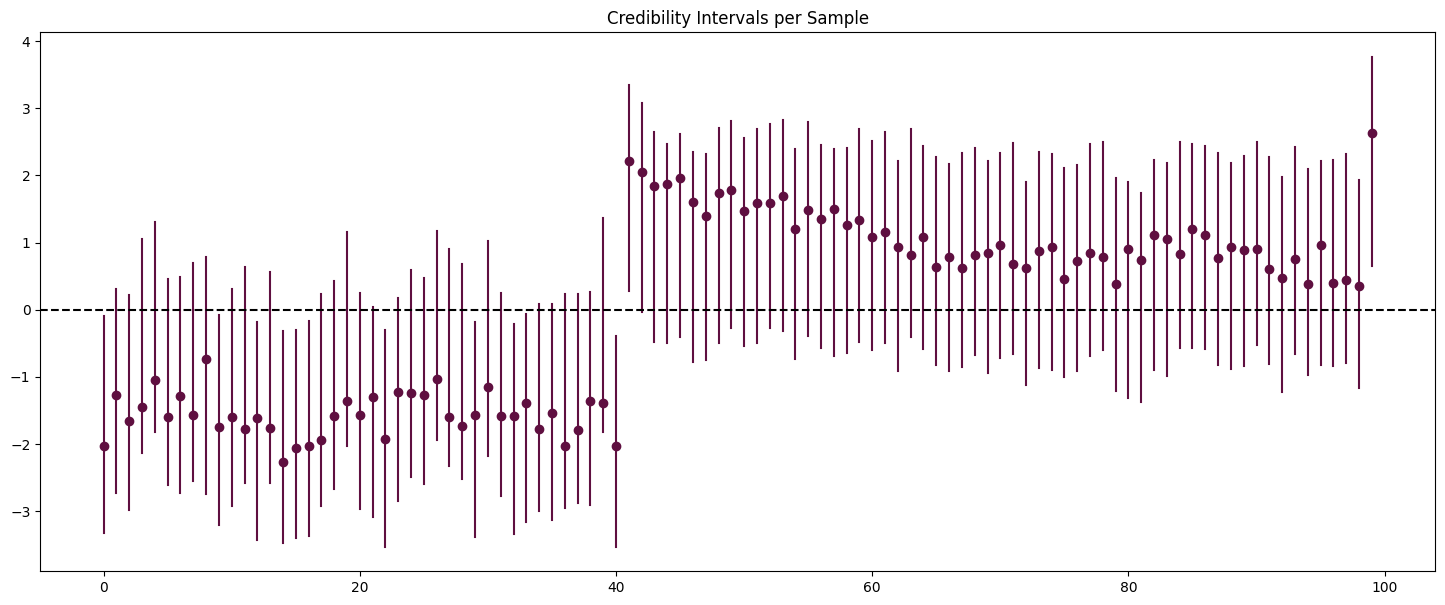

In [26]:
fig, axs = plt.subplots(1,1, figsize=(18,7))
bmlf.plot_with_credibility_intervals( Y2[:,None], bmlf.convert_chain_draw_to_sample( preds ).transpose('sample','sample_idx','target_out_idx').values )
axs.set_title('Credibility Intervals per Sample')

## Projections on the Latent Space against the Target

In [27]:
η_train_xr = \
bmlf.sample_projection_on_varimaxed_space(rng.integers(1000000), idata, Varimax_res_xr)

Text(0.5, 0.98, 'Projection using both Spectrum and Moisture')

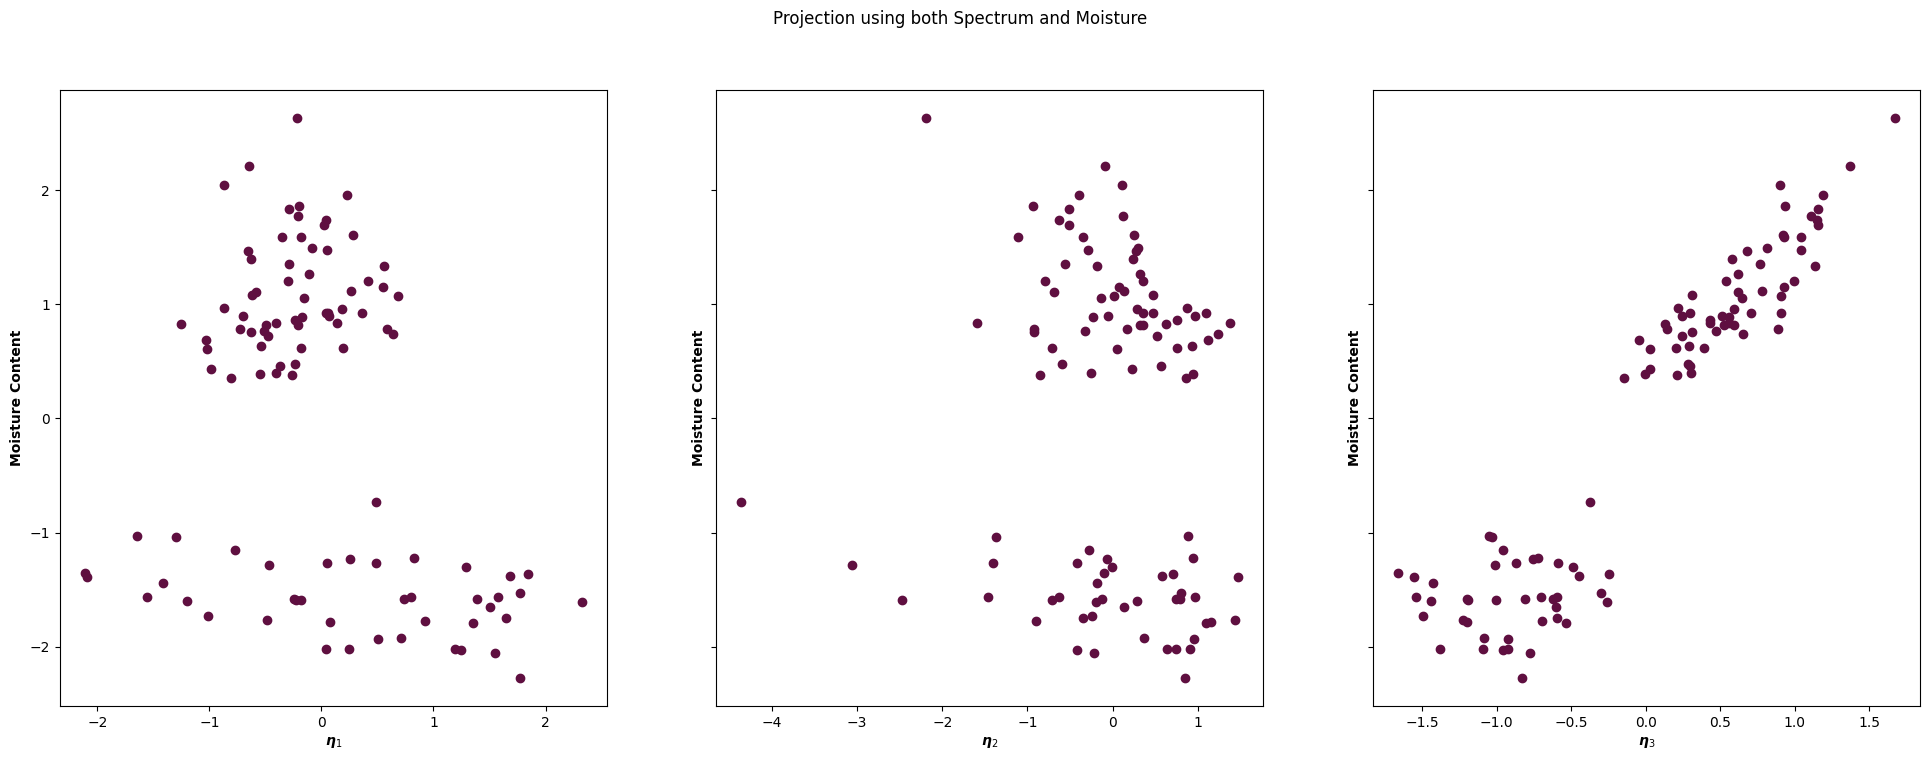

In [28]:
fig, ax = plt.subplots(1,3, figsize=(24,8), sharey=True)
for i in range(3):
    ax[i].scatter( η_train_xr.mean('chain').mean('draw').sel(latent_factor_idx=i).values , Y2 , c=bmlf.default_color_dict['Tyrian purple'] )
    ax[i].set_xlabel(r'$\boldsymbol{\eta}_{'+str(i+1)+'}$')
    ax[i].set_ylabel('Moisture Content', weight='bold')

fig.suptitle('Projection using both Spectrum and Moisture')

In [29]:
η_xr = \
bmlf.sample_projection_on_varimaxed_space(rng.integers(1000000), idata, Varimax_res_xr, X_test=idata.constant_data['X'].values, Y1_test=idata.observed_data['y1'].values)

Text(0.5, 0.98, 'Projection using only Spectrum')

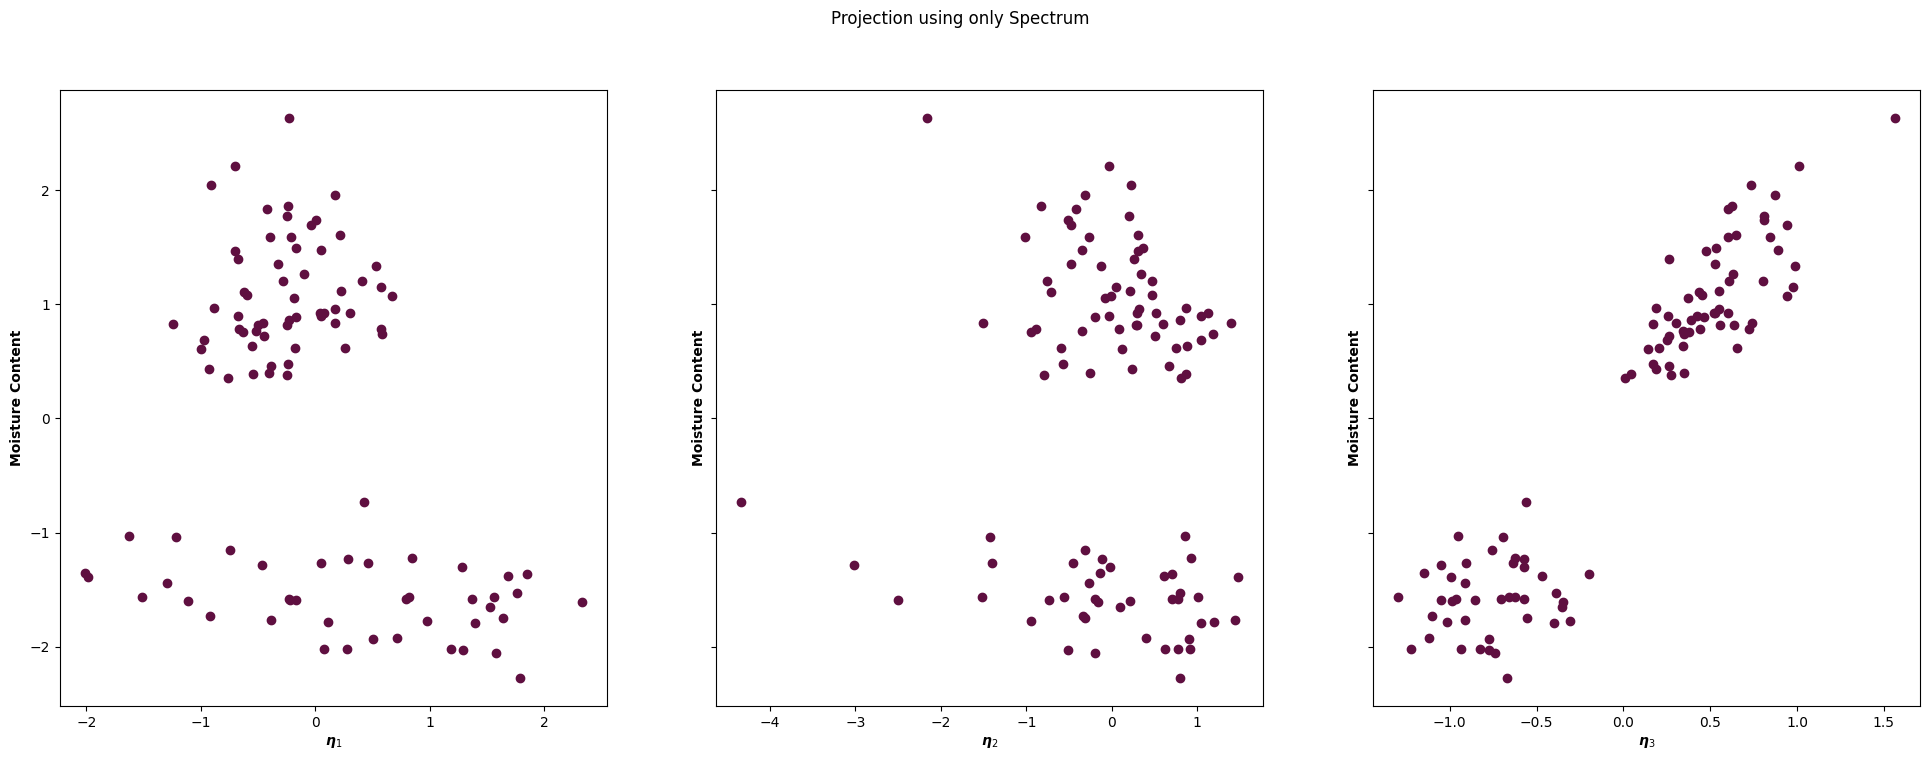

In [30]:
fig, ax = plt.subplots(1,3, figsize=(24,8), sharey=True)
for i in range(3):
    ax[i].scatter( η_xr.mean('chain').mean('draw').sel(latent_factor_idx=i).values , Y2 , c=bmlf.default_color_dict['Tyrian purple'] )
    ax[i].set_xlabel(r'$\boldsymbol{\eta}_{'+str(i+1)+'}$')
    ax[i].set_ylabel('Moisture Content', weight='bold')

fig.suptitle('Projection using only Spectrum')